# Atividade Computacional 2

## Aluno: Dylan Faria Robson

## Import

In [1]:
# --- Importações Essenciais ---
import warnings

# Scikit-learn
import numpy as np, random, time, matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from deap import base, creator, tools
from tqdm.auto import tqdm, trange

# Visualização
import matplotlib.pyplot as plt

# --- Configurações Globais ---
warnings.filterwarnings('ignore', category=UserWarning) # Ignorar avisos de convergência do MLP

## Funções

In [ ]:
#Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# 1 · Carregar e normalizar a base MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data.astype(np.float32)/255.0, mnist.target.astype(np.int64)
X, y = shuffle(X, y, random_state=SEED)
# subamostrar 15000 itens
X, y = X[:15000], y[:15000]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED)

In [4]:
# 2 · Funções utilitárias
ACT = {'relu': lambda z: np.maximum(0,z),
       'logistic': lambda z: 1/(1+np.exp(-z))}

DEFAULT_EPOCHS = 5
CLASSIF_ITERS = 60


def build_autoencoder(X, hidden, lr):
    """Cria e treina um autoencoder; ignora camadas com 0 neurónios."""
    hidden_clean = [h for h in hidden if h > 0]
    if not hidden_clean:
        hidden_clean = [LAT_MIN]
    layers = tuple(hidden_clean + hidden_clean[::-1])
    ae = MLPRegressor(
        hidden_layer_sizes=layers,
        activation='relu',
        solver='adam',
        learning_rate_init=lr,
        max_iter=DEFAULT_EPOCHS,
        batch_size=256,
        random_state=SEED,
        verbose=False,
    )
    ae.fit(X, X)
    return ae


def encode_latent(X, ae):
    n_enc = len(ae.coefs_) // 2
    A = X
    for i in range(n_enc):
        A = ACT[ae.activation](A @ ae.coefs_[i] + ae.intercepts_[i])
    return A


def build_classifier(Z, y):
    clf = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='adam',
                        learning_rate_init=1e-3, alpha=1e-4, max_iter=CLASSIF_ITERS,
                        batch_size=128, random_state=SEED, verbose=False)
    clf.fit(Z, y)
    return clf


In [5]:
# 3 · Fitness
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,stratify=y_train,random_state=SEED)
_cache={}

def evaluate(ind):
    key=tuple(round(v,4) for v in ind)
    if key in _cache: return (_cache[key],)
    n1,n2,lat,lr=ind
    hidden=[int(n1),int(n2),int(lat)]
    ae=build_autoencoder(X_tr,hidden,lr)
    recon=ae.predict(X_val)
    mse=mean_squared_error(X_val,recon)
    fitness=-mse  # DEAP maximiza; minimizamos MSE via sinal negativo
    _cache[key]=fitness
    return (fitness,)

In [6]:
# 4 · DEAP
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

# permitir camadas opcionais: 0 neurónios significa «camada ausente»
N1_MIN, N1_MAX = 0, 256
N2_MIN, N2_MAX = 0, 128
LAT_MIN, LAT_MAX = 1, 64  # latente não pode ser 0
LR_MIN, LR_MAX = 1e-4, 5e-3

def init_ind():
    return creator.Individual([
        random.randint(N1_MIN, N1_MAX),
        random.randint(N2_MIN, N2_MAX),
        random.randint(LAT_MIN, LAT_MAX),
        10**random.uniform(np.log10(LR_MIN), np.log10(LR_MAX))])

toolbox = base.Toolbox()

toolbox.register('individual', init_ind)

toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', evaluate)

toolbox.register('mate', tools.cxTwoPoint)

toolbox.register('mutate', tools.mutPolynomialBounded,
                 low=[N1_MIN, N2_MIN, LAT_MIN, LR_MIN],
                 up=[N1_MAX, N2_MAX, LAT_MAX, LR_MAX],
                 eta=20, indpb=0.3)

toolbox.register('select', tools.selBest)


def var_or(pop, lam, cxpb, mutpb):
    off = []
    for _ in range(lam):
        ind = toolbox.clone(random.choice(pop))
        if random.random() < cxpb:
            ind2 = toolbox.clone(random.choice(pop)); toolbox.mate(ind, ind2)
        if random.random() < mutpb:
            toolbox.mutate(ind)
        del ind.fitness.values
        off.append(ind)
    return off


## Execução

In [7]:
# 5 · Evolution Strategy (ES) – 10 gerações
μ, λ, GEN = 8, 56 , 30  # =~7
pop_es = toolbox.population(n=μ)
es_curve = []
start_es = time.perf_counter()
for _ in trange(GEN, desc='ES', unit='gen'):
    offspring = var_or(pop_es, λ, 0.5, 0.5)
    invalid = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)
    pop_es = toolbox.select(offspring, μ) 
    best_now = max(pop_es, key=lambda i: i.fitness.values[0])
    es_curve.append(-best_now.fitness.values[0])
end_es = time.perf_counter()
hof_es = max(pop_es, key=lambda i: i.fitness.values[0])
es_time = end_es - start_es
es_mse = es_curve[-1]
print(f'ES – melhor MSE: {es_mse:.5f} | tempo {es_time:.1f}s')

ES:   0%|          | 0/30 [00:00<?, ?gen/s]

ES – melhor MSE: 0.02642 | tempo 1376.3s


In [ ]:
# 6 · Particle Swarm Optimisation (PSO)
PART, ITER = 56, 30 
ϕ_p, ϕ_g, ω = 1.5, 1.5, 0.7

pos = [np.array(init_ind(), dtype=float) for _ in range(PART)]
vel = [np.zeros(4) for _ in range(PART)]
fit = [evaluate(creator.Individual(p.tolist()))[0] for p in pos]
ppos, pbest = pos.copy(), fit.copy()
gbest_pos = pos[int(np.argmax(fit))].copy(); gbest = max(fit)
    
pso_curve = [-gbest]
start_pso = time.perf_counter()
for _ in trange(ITER, desc='PSO', unit='iter'):
    for i in range(PART):
        r_p, r_g = np.random.rand(4), np.random.rand(4)
        vel[i] = ω * vel[i] + ϕ_p * r_p * (ppos[i] - pos[i]) + ϕ_g * r_g * (gbest_pos - pos[i])
        pos[i] += vel[i]
        pos[i][:3] = np.clip(pos[i][:3], [N1_MIN, N2_MIN, LAT_MIN], [N1_MAX, N2_MAX, LAT_MAX])
        pos[i][3] = np.clip(pos[i][3], LR_MIN, LR_MAX)
        curr_fit = evaluate(creator.Individual(pos[i].tolist()))[0]
        if curr_fit > pbest[i]:
            pbest[i], ppos[i] = curr_fit, pos[i].copy()
        if curr_fit > gbest:
            gbest, gbest_pos = curr_fit, pos[i].copy()
    pso_curve.append(-gbest)
end_pso = time.perf_counter()

hof_pso = creator.Individual(gbest_pos.tolist()); hof_pso.fitness.values = (gbest,)
pso_time = end_pso - start_pso
pso_mse = pso_curve[-1]
print(f'PSO – melhor MSE: {pso_mse:.5f} | tempo {pso_time:.1f}s')

PSO:   0%|          | 0/30 [00:00<?, ?iter/s]

PSO – melhor MSE: 0.02303 | tempo 4340.8s


In [9]:
# 7 · Modelo final

results = []
for label, ind, mse, t_opt in [
    ('ES', hof_es, es_mse, es_time),
    ('PSO', hof_pso, pso_mse, pso_time)]:
    n1, n2, lat, lr = ind
    hidden = [int(n1), int(n2), int(lat)]
    ae = build_autoencoder(X_train, hidden, lr)
    Z_tr, Z_te = encode_latent(X_train, ae), encode_latent(X_test, ae)
    clf = build_classifier(Z_tr, y_train)
    pr = clf.predict(Z_te)
    acc = accuracy_score(y_test, pr)
    prec = precision_score(y_test, pr, average='macro')
    rec = recall_score(y_test, pr, average='macro')
    f1 = f1_score(y_test, pr, average='macro')
    results.append([label, mse, acc, prec, rec, f1, t_opt, hidden, lr])

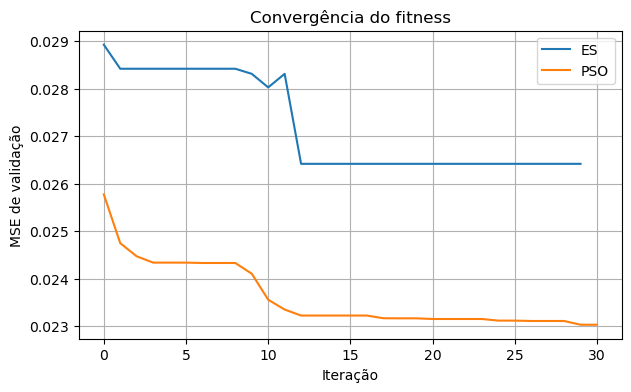

In [10]:
# 8 · Convergência
plt.figure(figsize=(7,4))
plt.plot(es_curve, label='ES')
plt.plot(range(0, ITER+1), pso_curve, label='PSO')
plt.xlabel('Iteração')
plt.ylabel('MSE de validação')
plt.title('Convergência do fitness')
plt.grid(True); plt.legend(); plt.show()


In [11]:
# 9 · Tabela comparativa
print("| Algoritmo | MSE (↓) | Acc | Prec | Rec | F1 | Tempo s | Hidden | LR |")
print("|-----------|---------|------|------|------|------|--------|----------------|-------|")
for algo, mse, acc, prec, rec, f1, t_opt, hidden, lr in results:
    print(f"| {algo} | {mse:.5f} | {acc:.4f} | {prec:.4f} | {rec:.4f} | {f1:.4f} | {t_opt:.1f} | {hidden} | {lr:.2e} |")

| Algoritmo | MSE (↓) | Acc | Prec | Rec | F1 | Tempo s | Hidden | LR |
|-----------|---------|------|------|------|------|--------|----------------|-------|
| ES | 0.02642 | 0.9143 | 0.9150 | 0.9136 | 0.9136 | 1376.3 | [131, 94, 36] | 2.30e-03 |
| PSO | 0.02303 | 0.9087 | 0.9082 | 0.9076 | 0.9077 | 4340.8 | [251, 128, 64] | 2.33e-03 |


## Resultado - tempo médio após 10 execuções

| Algoritmo | MSE (↓) | Acc | Prec | Rec | F1 | Tempo s | Hidden | LR |
|-----------|---------|------|------|------|------|--------|----------------|-------|
| ES | 0.02642 | 0.9143 | 0.9150 | 0.9136 | 0.9136 | 1037.3 | [131, 94, 36] | 2.30e-03 |
| PSO | 0.02303 | 0.9087 | 0.9082 | 0.9076 | 0.9077 | 3322.9 | [251, 128, 64] | 2.33e-03 |